In [3]:

import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import pickle
import numpy as np




In [4]:


df = pd.read_csv("Preprocessado_df.csv")

df['combined'] = df['title'].fillna('') + " " + df['text'].fillna('') # combinar texto com titulo da noticia
df = df.drop(['title'],axis="columns")
df = df.drop(['text'],axis="columns")
df = df.drop(['Unnamed: 0'],axis="columns")
df



,label,combined
0,1,law enforcement high alert following threat co...
1,1,unbelievable obama attorney general say charlo...
2,0,bobby jindal raised hindu us story christian c...
3,1,satan 2 russia unvelis image terrifying new su...
4,1,time christian group sue amazon splc designati...
...,...,...
71532,0,russian steal research trump hack u democratic...
71533,1,watch giuliani demand democrat apologize trump...
71534,0,migrant refuse leave train refugee camp hungar...
71535,0,trump tussle give unpopular mexican leader muc...


In [5]:


X = df['combined']  
y = df['label']  


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)


max_words = 50000  
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train) 

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

max_len = 120 
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)



In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2

model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=32, input_length=max_len))
model.add(LSTM(32, dropout=0.4, recurrent_dropout=0.4))
model.add(Dropout(0.6))  
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

c:\Users\alexa\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Treinar o modelo
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_train_pad, y_train, 
                    epochs=5,
                    batch_size=32, 
                    validation_data=(X_test_pad, y_test),
                    callbacks=[early_stopping])


Epoch 1/5
1565/1565 ━━━━━━━━━━━━━━━━━━━━ 46s 28ms/step - accuracy: 0.8373 - loss: 0.4589 - val_accuracy: 0.9268 - val_loss: 0.2060
Epoch 2/5
1565/1565 ━━━━━━━━━━━━━━━━━━━━ 43s 28ms/step - accuracy: 0.9412 - loss: 0.1759 - val_accuracy: 0.9254 - val_loss: 0.1966
Epoch 3/5
1565/1565 ━━━━━━━━━━━━━━━━━━━━ 43s 27ms/step - accuracy: 0.9593 - loss: 0.1287 - val_accuracy: 0.9376 - val_loss: 0.1870
Epoch 4/5
1565/1565 ━━━━━━━━━━━━━━━━━━━━ 43s 27ms/step - accuracy: 0.9684 - loss: 0.1028 - val_accuracy: 0.9343 - val_loss: 0.2084
Epoch 5/5
1565/1565 ━━━━━━━━━━━━━━━━━━━━ 44s 28ms/step - accuracy: 0.9730 - loss: 0.0889 - val_accuracy: 0.9376 - val_loss: 0.2150


In [13]:
from sklearn.metrics import classification_report, f1_score
y_pred = model.predict(X_test_pad)
y_pred = (y_pred > 0.5).astype(int)  
print(classification_report(y_test, y_pred))
f1 = f1_score(y_test, y_pred)
print(f"F1-Score: {f1}")

671/671 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step
              precision    recall  f1-score   support

           0       0.93      0.95      0.94     10469
           1       0.95      0.93      0.94     10993

    accuracy                           0.94     21462
   macro avg       0.94      0.94      0.94     21462
weighted avg       0.94      0.94      0.94     21462

F1-Score: 0.9384417493568541


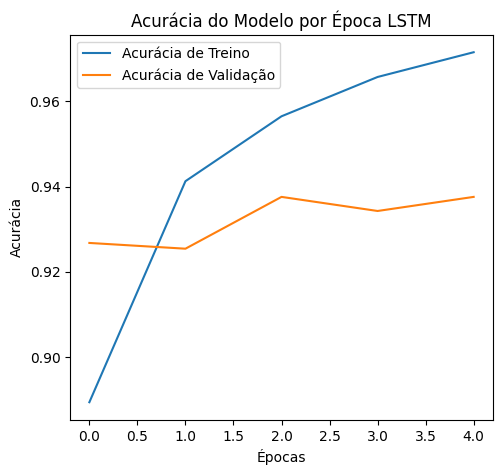

In [16]:
import matplotlib.pyplot as plt
# Plotando os gráficos de acurácia
plt.figure(figsize=(12, 5))

# Gráfico de acurácia
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Acurácia de Treino')
plt.plot(history.history['val_accuracy'], label='Acurácia de Validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.title('Acurácia do Modelo por Época LSTM')
plt.legend()

In [15]:
model.save('modelo_LSTM.keras')